# Word2Vec

In [1]:
import json
import re
import os
import pickle
from collections import Counter

import pandas as pd
from tqdm import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (20, 10)

from pymorphy2 import MorphAnalyzer
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from nltk.corpus import stopwords

from sklearn.cluster import KMeans

tqdm.pandas()

C:\Users\User\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
C:\Users\User\anaconda3\lib\site-packages\tqdm\std.py:697: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
responses = []
with open('../banki_responses.json', 'r', encoding='utf-8') as f:
    for i, row in enumerate(tqdm(f)):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)
len(responses)

201030it [00:28, 7087.05it/s]


153499

In [3]:
banki = pd.DataFrame(responses).drop('rating_not_checked', axis=1)
banki['datetime'] = pd.to_datetime(banki['datetime'])
banki.info()
banki

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   city          138325 non-null  object        
 1   title         153499 non-null  object        
 2   num_comments  153499 non-null  int64         
 3   bank_license  153498 non-null  object        
 4   author        153479 non-null  object        
 5   bank_name     153499 non-null  object        
 6   datetime      153499 non-null  datetime64[ns]
 7   text          153499 non-null  object        
 8   rating_grade  88658 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(6)
memory usage: 10.5+ MB


,city,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN
3,г. Ставрополь,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN
4,г. Челябинск,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN
...,...,...,...,...,...,...,...,...,...
153494,None,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0
153495,None,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
153496,None,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
153497,None,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


In [4]:
# Добавляем столбцы с токенами

def get_tokens(text):
    return re.findall(r'[А-Яа-я]+', text.lower())

banki['tokens'] = banki['text'].progress_apply(get_tokens)
banki['tokens_count'] = banki['tokens'].str.len()
banki

100%|███████████████████████████████████████████████████████████████████████| 153499/153499 [00:12<00:00, 12159.96it/s]


,city,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,tokens,tokens_count
0,г. Москва,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,"[добрый, день, я, не, являюсь, клиентом, банка...",213
1,г. Новосибирск,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,"[доброго, дня, являюсь, держателем, зарплатной...",135
2,г. Москва,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,"[здравствуйте, дублирую, свое, заявление, от, ...",83
3,г. Ставрополь,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,"[добрый, день, я, открыл, расчетный, счет, в, ...",121
4,г. Челябинск,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,"[г, взяла, кредит, в, вашем, банке, заявленная...",291
...,...,...,...,...,...,...,...,...,...,...,...
153494,None,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0,"[слишком, большой, банк, не, всегда, учитывает...",50
153495,None,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0,"[вы, сами, виноваты, в, своих, проблемах, кром...",112
153496,None,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0,"[уважаемое, руководство, банка, овк, я, прожив...",786
153497,None,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0,"[пробовала, оформить, товар, в, кредит, в, аль...",96


In [5]:
stopwords_set = set(stopwords.words('russian'))
list(stopwords_set)[:10]

['на', 'ли', 'сам', 'мы', 'этом', 'по', 'чтобы', 'надо', 'можно', 'не']

In [6]:
# Добавляем столбцы с леммами
morph = MorphAnalyzer()

lemmas_dict_filename = 'lemmas_dict.pkl'
if os.path.exists(lemmas_dict_filename):
    with open(lemmas_dict_filename, 'rb') as f:
        lemmas_dict = pickle.load(f)
else:
    lemmas_dict = {}

lemmas_cnt = Counter()

def get_lemmas(tokens):
    lemmas = []
    for word in tokens:
        if word in lemmas_dict:
            lemma = lemmas_dict[word]
        else:
            p = morph.parse(word)[0]
            lemma = p.normal_form
            lemmas_dict[word] = lemma
        lemmas.append(lemma)
        if lemma not in stopwords_set:
            lemmas_cnt[lemma] += 1
    return lemmas

banki['lemmas'] = banki['tokens'].progress_apply(get_lemmas)
if not os.path.exists(lemmas_dict_filename):
    with open(lemmas_dict_filename, 'wb') as f:
        pickle.dump(lemmas_dict, f)
banki

100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [01:14<00:00, 2050.58it/s]


,city,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade,tokens,tokens_count,lemmas
0,г. Москва,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN,"[добрый, день, я, не, являюсь, клиентом, банка...",213,"[добрый, день, я, не, являться, клиент, банк, ..."
1,г. Новосибирск,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN,"[доброго, дня, являюсь, держателем, зарплатной...",135,"[добрый, день, являться, держатель, зарплатный..."
2,г. Москва,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN,"[здравствуйте, дублирую, свое, заявление, от, ...",83,"[здравствуйте, дублировать, свой, заявление, о..."
3,г. Ставрополь,Меняют проценты комиссии не предупредив и не ...,2,лицензия № 1481,643609,Сбербанк России,2015-06-05 13:51:01,Добрый день!! Я открыл расчетный счет в СберБа...,NaN,"[добрый, день, я, открыл, расчетный, счет, в, ...",121,"[добрый, день, я, открыть, расчётный, счёт, в,..."
4,г. Челябинск,Верните денежные средства за страховку,1,лицензия № 2766,anfisa-2003,ОТП Банк,2015-06-05 10:58:12,"04.03.2015 г. взяла кредит в вашем банке, заяв...",NaN,"[г, взяла, кредит, в, вашем, банке, заявленная...",291,"[г, взять, кредит, в, ваш, банк, заявить, я, с..."
...,...,...,...,...,...,...,...,...,...,...,...,...
153494,None,Не все так страшно,0,лицензия № 2557,Вера,Ситибанк,2005-05-18 14:38:00,"Слишком большой банк, не всегда учитывает нашу...",5.0,"[слишком, большой, банк, не, всегда, учитывает...",50,"[слишком, большой, банк, не, всегда, учитывать..."
153495,None,А вы договор читали?,0,лицензия № 2557,Kirill,Ситибанк,2005-04-14 15:25:00,"Вы сами виноваты в своих проблемах, кроме пред...",3.0,"[вы, сами, виноваты, в, своих, проблемах, кром...",112,"[вы, сам, виноватый, в, свой, проблема, кроме,..."
153496,None,"Филиал банка ""ОВК"" в г. Иваново",1,лицензия № 2272,AlexU-post,Росбанк,2005-04-08 14:07:00,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0,"[уважаемое, руководство, банка, овк, я, прожив...",786,"[уважаемый, руководство, банк, овк, я, прожива..."
153497,None,В Альфа-Банк больше обращаться не буду.,0,лицензия № 1326,Ирина,Альфа-Банк,2005-04-14 15:16:00,Пробовала 10.04.05 оформить товар в кредит в А...,1.0,"[пробовала, оформить, товар, в, кредит, в, аль...",96,"[пробовать, оформить, товар, в, кредит, в, аль..."


In [7]:
lemmas_cnt.most_common(10)

[('банк', 668563),
 ('карта', 334999),
 ('это', 308689),
 ('деньга', 179819),
 ('день', 173116),
 ('всё', 171094),
 ('кредит', 156177),
 ('который', 149017),
 ('отделение', 144050),
 ('клиент', 136892)]

In [8]:
# обучение с помощью word2vec

wv_filename = 'word2vec.model'

if os.path.exists(wv_filename):
    model = Word2Vec.load(wv_filename)
else:
    model = Word2Vec(sentences=banki['lemmas'], vector_size=100, window=5, min_count=1, workers=4)
    model.save("word2vec.model")

In [9]:
# тест на определение ближайших слов

model.wv.most_similar('банк')

[('ситибанк', 0.6376471519470215),
 ('сбербанк', 0.5996331572532654),
 ('сбер', 0.5721388459205627),
 ('альф', 0.5642899870872498),
 ('росбанк', 0.5605881214141846),
 ('мкб', 0.5376659631729126),
 ('брс', 0.528124988079071),
 ('псб', 0.5017133951187134),
 ('бинбанка', 0.5012518167495728),
 ('совкомбанк', 0.4937206208705902)]

In [10]:
model.wv.most_similar('клиент')

[('вкладчик', 0.7468844652175903),
 ('клиентура', 0.6091889142990112),
 ('клиентка', 0.5881478190422058),
 ('заёмщик', 0.5787376761436462),
 ('клиенто', 0.5622684359550476),
 ('человек', 0.5417900681495667),
 ('девиз', 0.5083727836608887),
 ('посетитель', 0.5083528757095337),
 ('пользователь', 0.5077521800994873),
 ('предвзятый', 0.5018620491027832)]

In [11]:
model.wv.most_similar('деньга')

[('денежка', 0.864969789981842),
 ('дс', 0.7521470785140991),
 ('денюжка', 0.7389503121376038),
 ('наличка', 0.711467444896698),
 ('средство', 0.7043887972831726),
 ('нал', 0.6664370894432068),
 ('наличность', 0.6637088060379028),
 ('денюшка', 0.6419085264205933),
 ('обратно', 0.621414303779602),
 ('кровный', 0.6144148111343384)]

In [12]:
model.wv.most_similar(positive=['доверие', 'банк'], negative=['обман'])

[('сожаление', 0.43381693959236145),
 ('конкурент', 0.4191797375679016),
 ('альф', 0.40678122639656067),
 ('брэндинговый', 0.40157419443130493),
 ('переживательный', 0.37992915511131287),
 ('счастие', 0.37779009342193604),
 ('многоуважаевымый', 0.37213048338890076),
 ('прикрепиться', 0.3668742775917053),
 ('словоформа', 0.36206912994384766),
 ('парна', 0.36082905530929565)]

In [13]:
# тест на аналогии

print(model.wv.similarity('клиент', 'вкладчик'))

0.7468844


In [14]:
# тест на определение лишнего слова

words = ['банк', 'город', 'деньга', 'доверие', 'обман', 'клиент']
model.wv.doesnt_match(words)

'город'

In [15]:
# визуализация

def plot_vector(vector):
    x = np.linspace(1, len(vector), num=len(vector))
    y = vector

    fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True)
    fig.set_size_inches(20, 3)

    extent = [x[0]-(x[1]-x[0])/2., x[-1]+(x[1]-x[0])/2.,0,1]
    ax.imshow(y[np.newaxis,:], cmap="plasma", aspect="auto", extent=extent)
    ax.set_yticks([])
    ax.set_xlim(extent[0], extent[1])
    ax2.plot(x,y)
    plt.tight_layout()
    plt.show()

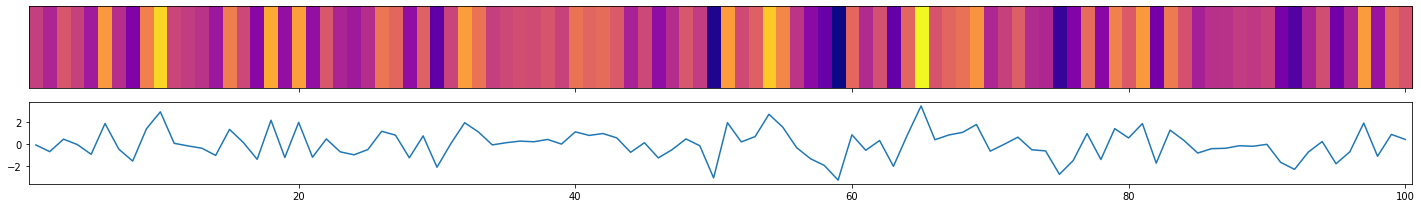

In [16]:
good_bad_vec = model.wv['хорошо'] - model.wv['плохо']
plot_vector(good_bad_vec)

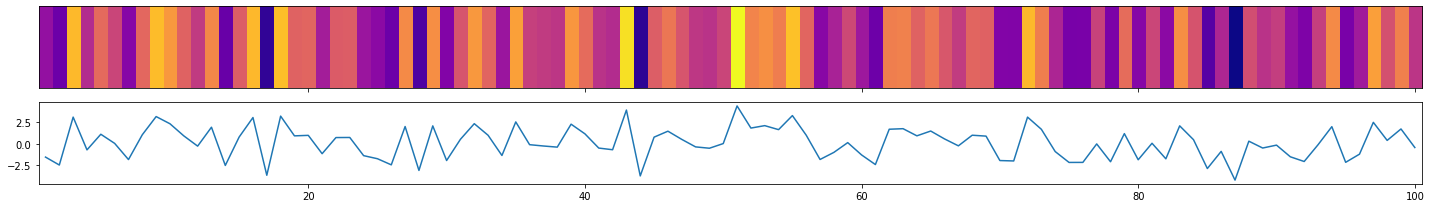

In [17]:
fast_slow_vec = model.wv['быстро'] - model.wv['медленно']
plot_vector(fast_slow_vec)

In [18]:
np.array(lemmas_cnt.most_common(30))[:, 0]

array(['банк', 'карта', 'это', 'деньга', 'день', 'всё', 'кредит',
       'который', 'отделение', 'клиент', 'сотрудник', 'мочь', 'счёт',
       'свой', 'сказать', 'сумма', 'заявление', 'год', 'вопрос', 'время',
       'ещё', 'получить', 'кредитный', 'весь', 'ответ', 'вклад', 'офис',
       'телефон', 'платёж', 'договор'], dtype='<U9')

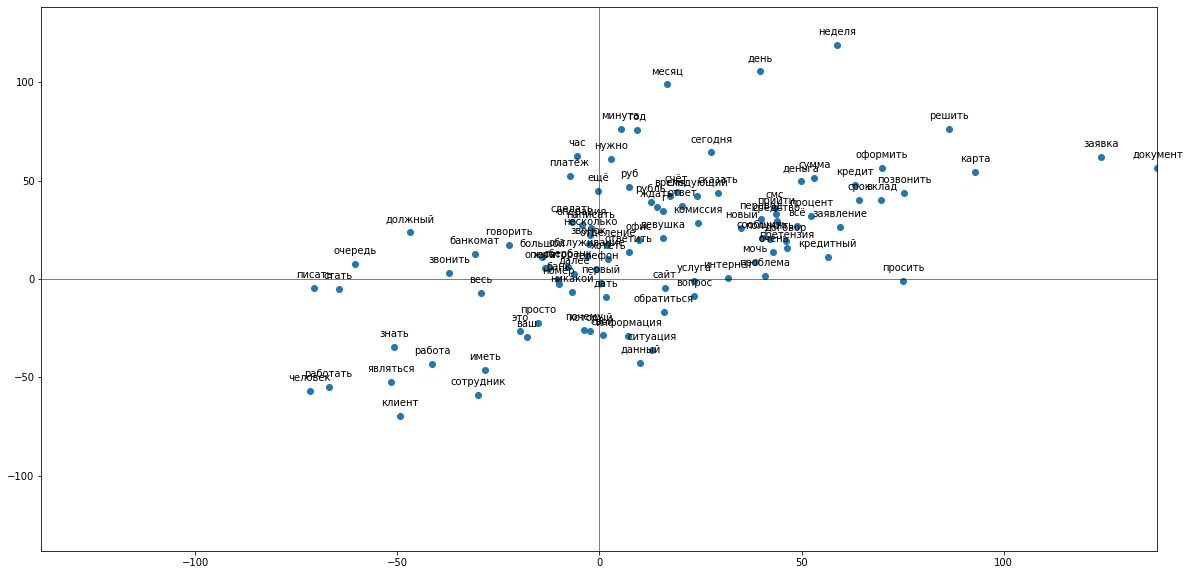

In [19]:
# построение в координатах "плохо - хорошо", "медленно - быстро"


words = np.array(lemmas_cnt.most_common(100))[:, 0]

max_lim = 0
xs = []
ys = []

for word in words:
    x = np.dot(fast_slow_vec, model.wv[word])
    y = np.dot(good_bad_vec, model.wv[word])
    max_lim = max(max_lim, abs(x), abs(y))
    xs.append(x)
    ys.append(y)
    
    plt.annotate(word, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# plot the points
plt.scatter(xs, ys)
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axvline(x=0, color='k', linewidth=0.5)
plt.xlim(-max_lim, max_lim)
plt.ylim(-max_lim, max_lim)
plt.show()

In [20]:
# определение координат "плохо - хорошо", "медленно - быстро"

words_df = pd.DataFrame({ 'word': words, 'x': xs, 'y': ys })
words_df

,word,x,y
0,банк,-10.173631,-0.591767
1,карта,93.005844,54.522743
2,это,-19.555622,-26.330547
3,деньга,49.788498,49.608917
4,день,39.666351,105.505959
...,...,...,...
95,писать,-70.515259,-4.608127
96,комиссия,24.423450,28.198326
97,следующий,24.240896,41.949677
98,хотя,-13.551356,5.376942


In [21]:
X = words_df[['x', 'y']]
X

,x,y
0,-10.173631,-0.591767
1,93.005844,54.522743
2,-19.555622,-26.330547
3,49.788498,49.608917
4,39.666351,105.505959
...,...,...
95,-70.515259,-4.608127
96,24.423450,28.198326
97,24.240896,41.949677
98,-13.551356,5.376942


In [22]:
# построение осмысленных кластеров слов

kmeans = KMeans().fit(X)
words_df['labels'] = kmeans.labels_
words_df

,word,x,y,labels
0,банк,-10.173631,-0.591767,1
1,карта,93.005844,54.522743,2
2,это,-19.555622,-26.330547,3
3,деньга,49.788498,49.608917,6
4,день,39.666351,105.505959,7
...,...,...,...,...
95,писать,-70.515259,-4.608127,4
96,комиссия,24.423450,28.198326,6
97,следующий,24.240896,41.949677,5
98,хотя,-13.551356,5.376942,1


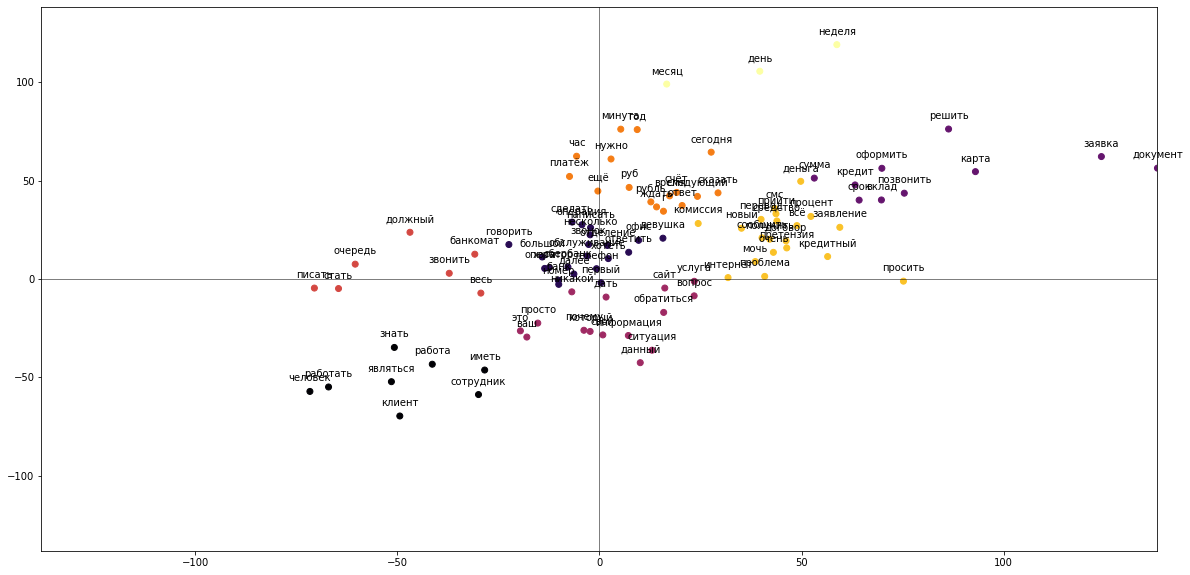

In [23]:
max_lim = 0

for i, row in words_df.iterrows():
    word = row['word']
    x = row['x']
    y = row['y']
    max_lim = max(max_lim, abs(x), abs(y))
    
    plt.annotate(word, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

# plot the points
plt.scatter(words_df['x'], words_df['y'], c=words_df['labels'], cmap='inferno')
plt.axhline(y=0, color='k', linewidth=0.5)
plt.axvline(x=0, color='k', linewidth=0.5)
plt.xlim(-max_lim, max_lim)
plt.ylim(-max_lim, max_lim)
plt.show()